# Оптимизация маркетинговых затрат в Яндекс.Афише


### Описание проекта

Оптимизация маркетинговых затрат на основании данных Яндекс.Афиши с июня 2017 по конец мая 2018 года.

На основании имеющихся данных требуется провести анализ о том, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда клиент окупается.

### Содержание <a id="content"></a>

Шаг 1. [Изучение и подготовка данных](#step_1)

Шаг 2. [Построение отчетов и расчет метрик](#step_2)
   * [Продукт](#product)
        - Сколько людей пользуются в день, неделю, месяц?
        - Сколько сессий в день?
        - Сколько длится одна сессия?
        - Как часто люди возвращаются?
   * [Продажи](#sales)
        - Когда люди начинают покупать?
        - Сколько раз покупают за период?
        - Какой средний чек?
        - Сколько денег приносят? (LTV)
   * [Маркетинг](#marketing)
        - Сколько денег потратили? Всего / на каждый источник / по времени
        - Сколько стоило привлечение одного покупателя из каждого источника?
        - На сколько окупились расходы? (ROI)

    Построение графиков: как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

Шаг 3. [Вывод](#resume)

### Шаг 1. Изучение и подготовка данных <a id="step_1"></a>
[к содержанию](#content)

Импортируем библиотеки и прочитаем данные из файлов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

    display(visits.head(),
        orders.head(),
        costs.head()
       )

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Общая информация о файлах

In [2]:
display(visits.info(),
        orders.info(),
        costs.info()
       )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 

None

None

None

Проверим на дубликаты

In [3]:
print('Количество дубликатов в данных о заказах:', orders.duplicated().sum())
print('Количество дубликатов в данных о затратах:', costs.duplicated().sum())

Количество дубликатов в данных о заказах: 0
Количество дубликатов в данных о затратах: 0


* Названия столбцов следует привести к нижнему регистру и исключить пробелы
* Пропуски данных отсутствуют
* Дубликаты отсутствуют
* Типы данных столбцов `End Ts`, `Start Ts`, `Buy Ts`, `dt` нужно привести к формату `datetime`

Приведем названия к "правильному виду". Таблица costs имеет правильные заголовки, преобразования не требуется.

In [4]:
visits.columns = map(str.lower, visits.columns.str.replace(' ','_'))
orders.columns = map(str.lower, orders.columns.str.replace(' ','_'))

Переведем значения столбцов в тип даты

In [5]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

Оценим результаты преобразований

In [6]:
display(visits.info(),
        orders.info(),
        costs.info()
       )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2

None

None

None

Наименование столбцов и типы данных приведены к нужному формату. Столбцы `source_id` и `uid` имеются в различных таблицах и могут являться ключами для объединения, формат данных в них идентичен. Можно приступать к изучению информации.

Описание данных:

Таблица **visits** (лог сервера с информацией о посещениях сайта):
   * uid — уникальный идентификатор пользователя
   * device — категория устройства пользователя
   * start_ts — дата и время начала сессии
   * end_ts — дата и время окончания сессии
   * source_id — идентификатор рекламного источника, из которого пришел пользователь
   
Таблица **orders** (информация о заказах):
   * uid — уникальный id пользователя, который сделал заказ
   * buy_ts — дата и время заказа
   * revenue — выручка Яндекс.Афиши с этого заказа
   
Таблица **costs** (информация о затратах на маркетинг):
   * source_id — идентификатор рекламного источника
   * dt — дата
   * costs — затраты на этот рекламный источник в этот день

Перед тем, как отвечать на основные вопросы, посмотрим на содержание данных в таблицах.

In [7]:
#основная информация по таблице visits
print('Всего пользователей: ', len(visits['uid']))
print('Всего уникальных пользователей: ', len(visits['uid'].unique()))
print('Процент уникальных пользователей: ', round(len(visits['uid'].unique())/len(visits['uid'])*100))
print('Начало периода: ', visits['start_ts'].min())
print('Окончание периода: ', visits['end_ts'].max())

#сводная информация о переходах: источники и устройства
source_visits = visits.pivot_table(index = 'source_id', columns ='device', values = 'uid', aggfunc = 'count')
source_visits.sort_values(by = ['desktop','touch'], ascending = False)

Всего пользователей:  359400
Всего уникальных пользователей:  228169
Процент уникальных пользователей:  63
Начало периода:  2017-06-01 00:01:00
Окончание периода:  2018-06-01 01:26:00


device,desktop,touch
source_id,,
4,67640,34154
3,65777,19833
5,50069,16836
2,35661,11965
1,25901,8220
9,10119,3158
10,7367,2658
7,28,8
6,5,1


**Вывод.** Всего в таблице `visits` за период с июня 2017 по конец мая 2018 года (подтверждаем исходную информацию о периоде  данных) 359400 записей, из них 63% уникальных пользователей (228169), значит, около **37% пользователей используют Афишу повторно**. **С десктопных устройств пользователей приходит больше**. Построен рейтинг об источниках трафика, по которому заметно **минимальное число переходов по источникам 6 и 7, а 8 - вообще отсутствует**.

In [8]:
#основная информация по таблице orders
print('Всего заказов: ', len(orders['uid']))
print('Всего уникальных пользователей, совершивших заказ: ', len(orders['uid'].unique()))
print('Процент уникальных пользователей, совершивших заказ: ', round(len(orders['uid'].unique())/len(orders['uid'])*100))
print('Начало периода: ', orders['buy_ts'].min())
print('Окончание периода: ', orders['buy_ts'].max())
orders_total = orders['revenue'].sum()
print('Сумма заказов : ', round(orders_total,2))
print('Средняя сумма заказа (средний чек за период) : ', round(orders['revenue'].mean(),2))
print('Максимальная сумма заказа: ', round(orders['revenue'].max(),2))
print('Минимальная сумма заказа: ', round(orders['revenue'].min(),2))
print('Количество заказов с минимальной суммой: ', orders['revenue'][orders['revenue'] == orders['revenue'].min()].count())

Всего заказов:  50415
Всего уникальных пользователей, совершивших заказ:  36523
Процент уникальных пользователей, совершивших заказ:  72
Начало периода:  2017-06-01 00:10:00
Окончание периода:  2018-06-01 00:02:00
Сумма заказов :  252057.2
Средняя сумма заказа (средний чек за период) :  5.0
Максимальная сумма заказа:  2633.28
Минимальная сумма заказа:  0.0
Количество заказов с минимальной суммой:  51


**Вывод.** Всего в таблице `orders` за период с июня 2017 по конец мая 2018 года (последний заказ осуществлен уже в первые часы июня 2018г.) 50415 записей, из них 72% заказов совершено уникальными пользователями (36523), значит, около **28% пользователей совершили повторный заказ**. Сумма всех заказов составляет 252057.2; Седний чек - 5.0; Максимальный заказ 2633.28. Однако, имеется 51 заказ с нулевой суммой. Это могут быть акционные предложения или оплата не в денежном выражении. Когортный анализ будет более информативен. <a id="source_id_table"></a>

In [9]:
#основная информация по таблице costs
costs_total = costs['costs'].sum()
print('Суммарные затраты на маркетинг : ', round(costs_total,2))
print('Начало периода: ', costs['dt'].min())
print('Окончание периода: ', costs['dt'].max())

#сводная информация о затратах
source_costs = costs.pivot_table(index = 'source_id', values = 'costs', aggfunc = 'sum')
source_costs = source_costs.sort_values(by ='costs', ascending = False)
source_costs

Суммарные затраты на маркетинг :  329131.62
Начало периода:  2017-06-01 00:00:00
Окончание периода:  2018-05-31 00:00:00


,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


In [10]:
romi = (orders_total-costs_total)/costs_total
romi

-0.2341750695360112

**Вывод.** В таблице `costs` <a id="costs"></a> информация соответствует периоду с июня 2017 по конец мая 2018 года. Суммарные затраты на маркетинг (329131.62) превысили выручку на 23%, в таблице нет информации об источниках трафика **6, 7 и 8, значит, они не имеют стоимости**. За весь период **почти половина всех затрат** пришлась на источник **№3**.

#### *Вывод по шагу 1. Данные подготовлены для анализа и изучены. Суммарные затраты за весь год превысили суммарную выручку. Следует определить в динамике, как ведут себя пользователи, и существуют ли результативные источники трафика.* 


### Шаг 2. Построение отчетов и расчет метрик<a id="step_2"></a>
[к содержанию](#content)

#### Продукт<a id="product"></a>
[к содержанию](#content)
  1. Сколько людей пользуются в день, неделю, месяц?
  2. Сколько сессий в день?
  3. Сколько длится одна сессия?
  4. Как часто люди возвращаются?


1. Оценка пользовательской активности. Определим метрики:

In [11]:
#Добавление столбцов для группировок
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее:

In [12]:
#пользовательские метрики
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean() 

print('DAU: ', int(dau_total))
print('WAU: ', int(wau_total))
print('MAU: ', int(mau_total))

DAU:  907
WAU:  5716
MAU:  23228


Чтобы увидеть изменение количества уникальных пользователей в динамике, построим графики. Здесь и далее графики, построенные по дням характерисуют изменение показателя в короткий промежуток времени и имеют больше пиковых значений, если изучаемая величина изменяется неравномерно. С увеличением временного интервала (неделя, месяц) график более "сглаживается"(усредняется) - такие графики позволяют оценить тенденцию.

*График ежедневной активности пользователей*<a id="customers"></a>

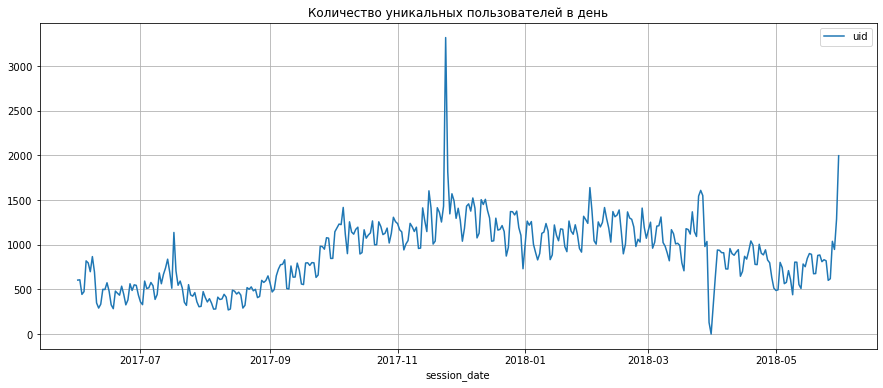

In [13]:
visits.groupby('session_date').agg({'uid': 'nunique'}).plot(grid = True, figsize = (15,6), title = 'Количество уникальных пользователей в день');

Наблюдается пик перед Новогодними каникулами: Это может быть результатом рекламной кампании (определим позже), или предновогодние приготовления и инициатива самих пользователей. Имеется и провал в апреле. Предположительно: сбой в работе сайта, или технический сбой в определении количества (накануне значительный рост).
[Ранее](#early) мы пришли к выводу о том, что пользователей Афиши больше на десктопных устройствах. Оценим метрику DAU в зависимости от категории устройства.

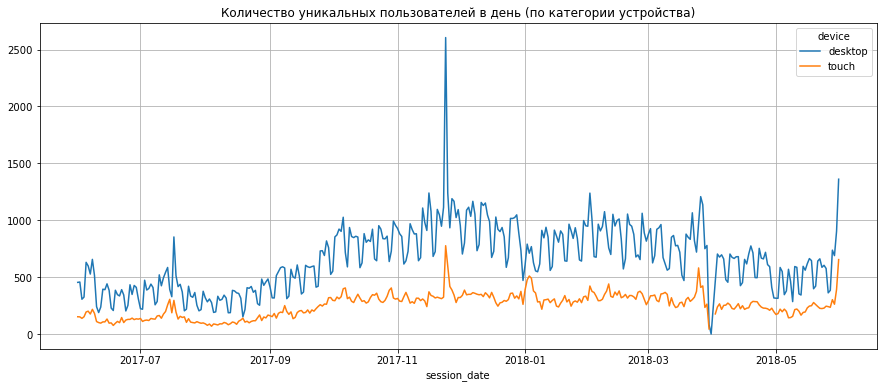

In [14]:
visits.pivot_table(index = 'session_date', columns = 'device', values = 'uid', aggfunc = 'nunique').plot(grid = True, figsize = (15,6), title = 'Количество уникальных пользователей в день (по категории устройства)');

Десктопные и мобильные пользователи демонстрируют похожую активность, хотя в холодное время года количество "десктопников" увеличивается больше.
Графики имеют характерные повторения (спады активности). Если на графиках изменения WAU таких спадов нет (а их нет, это видно на графике WAU), то вероятно снижение активности в некоторые дни недели. Проверим предположение, построив график на коротком интервале, например, за две недели февраля 2018 года: с 05.02.18 по 18.02.18. Примечательно, что у мобильных пользователей таких спадов нет.

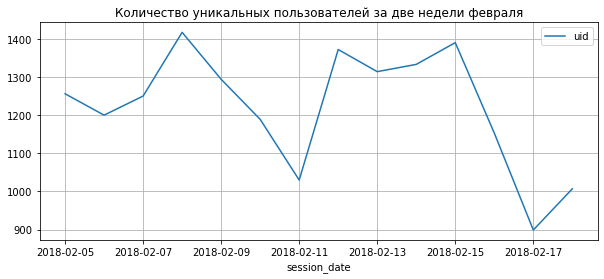

In [15]:
#проверка предположения о цикличности недельных посещений
startdate = pd.to_datetime("2018-02-04").date()
enddate = pd.to_datetime("2018-02-19").date()
(visits[(visits['session_date'] > startdate) & (visits['session_date'] < enddate)]
 .groupby('session_date').agg({'uid': 'nunique'}).plot(grid = True, figsize = (10,4)
 , title = 'Количество уникальных пользователей за две недели февраля')
);

Определены графики количества уникальных пользователей, ежедневно посещающих Яндекс.Афишу. Пользователи десктопных устройств снижают активность в выходные дни. На графике виден значительный всплеск в декабре и резкий провал в апреле, эти отклонения наблюдаются у пользователей обеих категорий устройств.

*График еженедельной активности пользователей*

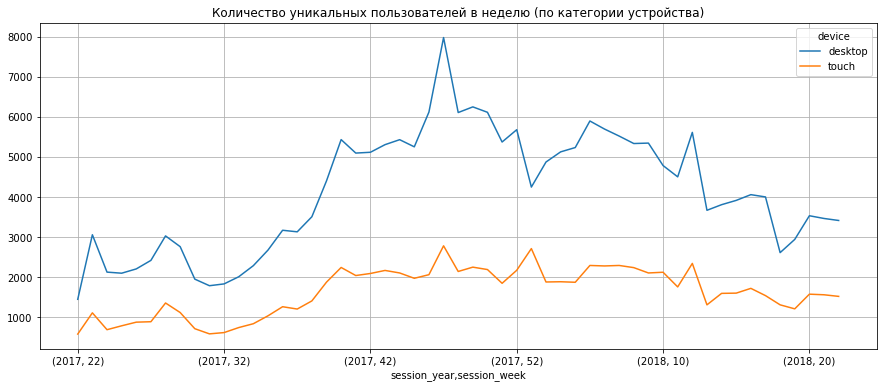

In [16]:
(visits.pivot_table(index = ['session_year', 'session_week'],
   columns = 'device', values = 'uid', aggfunc = 'nunique')
   .plot(grid = True, figsize = (15,6), title = 'Количество уникальных пользователей в неделю (по категории устройства)')
);

В январские каникулы единственный раз наблюдается противоположная активность пользователе мобильных и десктопных устройств. В период общего спада использования ресурса, чать десктопных пользователей, видимо, перешла на мобильную версию.

*График ежемесячной активности пользователей*

Построим графики ежемесячной активности пользователей с разбивкой по категории устройства и источнику трафика

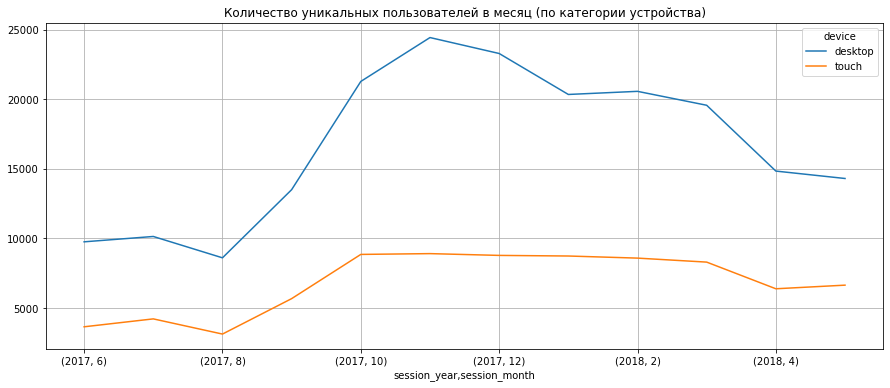

In [17]:
(visits.pivot_table(index = ['session_year', 'session_month']
, columns = 'device', values = 'uid', aggfunc = 'nunique')
.plot(grid = True, figsize = (15,6), title = 'Количество уникальных пользователей в месяц (по категории устройства)')
);

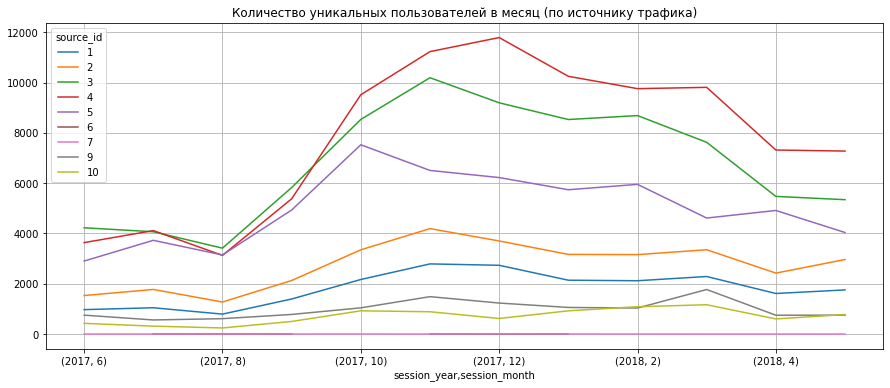

In [18]:
(visits.pivot_table(index = ['session_year', 'session_month']
, columns = 'source_id', values = 'uid', aggfunc = 'nunique')
.plot(grid = True, figsize = (15,6), title = 'Количество уникальных пользователей в месяц (по источнику трафика)')
);

График ежемесячной активности аналогичен предыдущим (но с усреднением), на графике с разбивкой по источнику трафика определяется рост пользователей, перешедших с источников **№4, №3, №5**

In [19]:
#"липкий фактор"
sticky_mau = (dau_total / mau_total) * 100
sticky_wau = (dau_total / wau_total) * 100
print('Коэффициент вовлеченности за неделю (DAU/WAU)', sticky_wau)
print('Коэффициент вовлеченности за месяц (DAU/MAU)', sticky_mau)

Коэффициент вовлеченности за неделю (DAU/WAU) uid    15.884409
dtype: float64
Коэффициент вовлеченности за месяц (DAU/MAU) uid    3.90897
dtype: float64


**Вывод.** На графике ежемесячной активности - являются "усреднением" предыдущих графиков, здесь явно заметно еще большее увеличение количества пользователей десктопной версии сайта в зимний период. Пользовательская активность за год увеличилась, не смотря на тенденцию к летнему снижению, к июню текущего периода пользователей уже значительно больше. Наиболее результативен источник трафика №4. Индекс лояльности (вовлеченности) за неделю составляет почти 16%. 

2. Количество сессий в день
     * Это показатель регулярности использования ресурса.

In [20]:
sessions_per_user = visits.groupby(['session_date']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.sort_values(by = 'sessions_per_user', ascending = False)

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-11-24,4042,3319,1.217837
2017-11-28,1746,1493,1.169457
2017-11-25,2089,1817,1.149697
2018-02-01,1878,1640,1.145122
2017-11-29,1480,1296,1.141975
...,...,...,...
2017-06-24,340,328,1.036585
2017-06-17,337,328,1.027439
2017-08-19,300,292,1.027397


**Вывод.** В среднем пользователь проводит одну сессию в день, но некоторые и больше. В созданной таблице снова наблюдаем рекордные посещения, которые пришлись на конец ноября.

3. Продолжительность сессии.

In [21]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].mean()

643.506488592098

Среднее значение - более 10 минут. Построим график средних значений сессии в месяц, с распределением по типу устройства и по источнику привлечения, чтобы оценить изменение протолжительности сессий с течением времени.

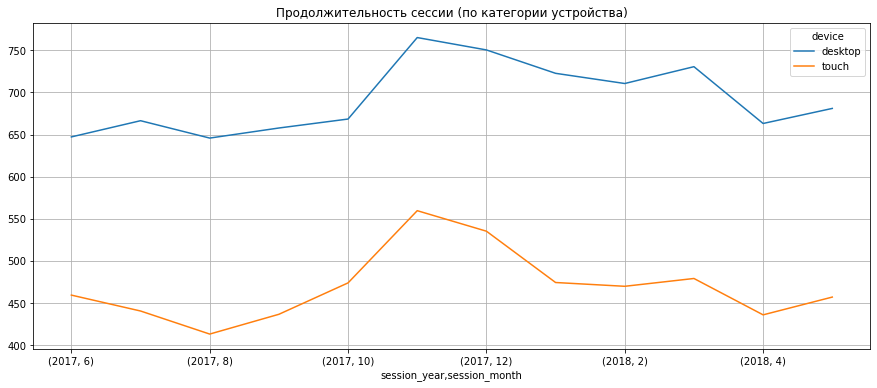

In [22]:
(visits.pivot_table(index = ['session_year', 'session_month']
, columns = 'device', values = 'session_duration_sec', aggfunc = 'mean')
.plot(grid = True, figsize = (15,6), title = 'Продолжительность сессии (по категории устройства)')
);

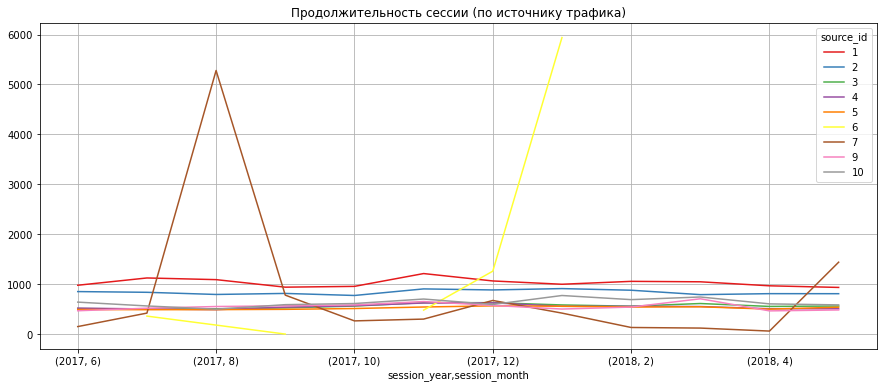

In [23]:
(visits.pivot_table(index = ['session_year', 'session_month']
, columns = 'source_id', values = 'session_duration_sec', aggfunc = 'mean')
.plot(grid = True, figsize = (15,6), colormap='Set1', title = 'Продолжительность сессии (по источнику трафика)')
);

Продолжительность сессии на мобильных устройствах короче. В ноябре не только пользователей больше, но и времени на сайте они проводили больше. На графике о продолжительности сессии бросается в глаза резкий рост по источнику №7 в августе и разорванные значения с резким ростом по источнику №6 в январе. Это могут быть статистические выбросы. Статистические выбросы оказывают влияние на среднее значение. Построим гистограмму частот, чтобы оценить распределение. Для определения интервала отображения графика оценим распределение в числовых величинах.

In [24]:
visits.groupby('session_duration_sec').agg({'session_duration_sec':['count']})                                             

,session_duration_sec
,count
session_duration_sec,
0,35794
19,868
60,53029
120,35748
180,26672
...,...
32880,1
35760,1


Максимальная длительность сессии длилась 7 часов (отвлекся на работу...?). Наблюдем значительное количество нулевых сессий (10% от всех) и незначительное количество сессий, длительностью 19 сек. (хотя, значения обычно кратны 60). Посмотрим на содержание таких строк.

In [25]:
display(visits[visits['session_duration_sec']== 0].sample(5), visits[visits['session_duration_sec']== 19].sample(5))

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec
135148,desktop,2017-11-23 20:24:00,2,2017-11-23 20:24:00,10009348675633147748,2017,11,47,2017-11-23,0
31950,desktop,2018-04-16 18:07:00,4,2018-04-16 18:07:00,1668840661974193372,2018,4,16,2018-04-16,0
142688,desktop,2018-04-16 15:06:00,3,2018-04-16 15:06:00,16625193296751416217,2018,4,16,2018-04-16,0
14153,desktop,2018-02-09 14:30:00,10,2018-02-09 14:30:00,17353316599280955744,2018,2,6,2018-02-09,0
54776,desktop,2017-06-28 10:45:00,5,2017-06-28 10:45:00,9563876747574771509,2017,6,26,2017-06-28,0


,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec
358572,touch,2017-10-06 22:28:19,4,2017-10-06 22:28:00,916160031189322188,2017,10,40,2017-10-06,19
359020,desktop,2018-03-17 12:22:19,5,2018-03-17 12:22:00,10408463741007306241,2018,3,11,2018-03-17,19
358602,touch,2017-10-09 15:41:19,3,2017-10-09 15:41:00,1506012995749374414,2017,10,41,2017-10-09,19
359275,desktop,2017-08-24 12:10:19,5,2017-08-24 12:10:00,15697493435449914960,2017,8,34,2017-08-24,19
359372,desktop,2017-12-19 21:41:19,5,2017-12-19 21:41:00,17875181850866691027,2017,12,51,2017-12-19,19


Вероятно, нулевыми засчитываются сессии, длящиеся меньше минуты (посмотрели и ушли). Сессии, длительностью 19 секунд, вероятно, результат технического сбоя, требуется уточнение.

Для построения графика распределения используем иртервал значений от минуты до часа, число корзин в этом случае = 60 
(3600/60)

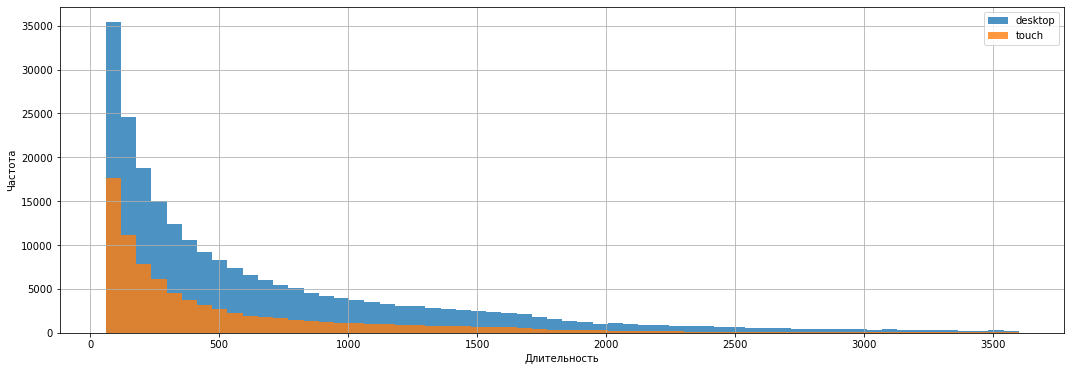

In [26]:
ax = plt.figure(figsize=(18, 6))
plt.hist(x=visits.query('device == "desktop"')['session_duration_sec'],bins=60, range = (60, 3600), label  = 'desktop', alpha = 0.8)
plt.hist(x=visits.query('device == "touch"')['session_duration_sec'],  bins=60, range = (60, 3600), label = 'touch', alpha = 0.8)
plt.grid(True)
plt.ylabel('Частота')
plt.xlabel('Длительность')
 
plt.legend();

Аналогично построим гистограмму распределения длительности сессий в зависимости от источника трафика (в цикле используем индекс ранее созданного DataFrame `source_visits`

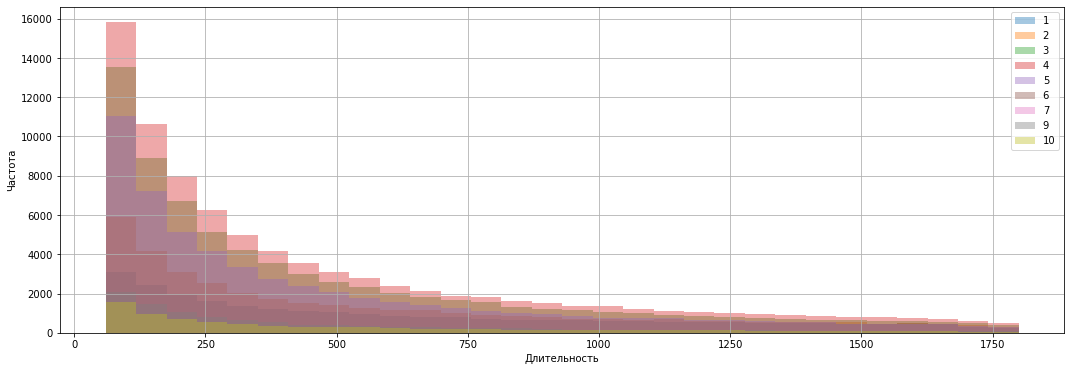

In [27]:
ax = plt.figure(figsize=(18, 6))
for i in source_visits.index:
    plt.hist(x=visits.query('source_id == @i')['session_duration_sec'],bins=30, range = (60, 1800), label  = i, alpha = 0.4)
plt.grid(True)
plt.ylabel('Частота')
plt.xlabel('Длительность')
 
plt.legend();

**Вывод** Наиболее частое значение длительности на любых устройствах - **1 минута**. Такой же результат был бы при вычислении моды (но на графике это нагляднее). Распределение частоты длительности сессий на обоих категориях устройств и для разных источников трафика имеют одинаковую форму графика.

4. Возвращаемость пользователей

Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые посетил ресурс.

In [28]:
#определяем месяц события, месяц первого визита и lifetime
first_visit = visits.groupby(['uid']).agg({'start_ts':'min'})
first_visit = first_visit.rename(columns={'start_ts':'first_visit'})
visits = visits.merge(first_visit, on='uid')

visits['visit_month'] = visits['session_date'].astype('datetime64[M]')
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')

visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1,'M')).round()
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype('int')

#формируем когорты
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

#считаем retention и сводную таблицу для тепловой карты
cohorts['retention'] = (cohorts['uid']/cohorts['cohort_users']).round(3)
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.079,0.054,0.061,0.069,0.071,0.061,0.058,0.052,0.051,0.041,0.045
2017-07-01,1.0,0.056,0.051,0.056,0.058,0.048,0.045,0.046,0.039,0.029,0.027,
2017-08-01,1.0,0.077,0.063,0.063,0.05,0.044,0.036,0.039,0.028,0.026,,
2017-09-01,1.0,0.085,0.069,0.051,0.039,0.038,0.036,0.024,0.023,,,
2017-10-01,1.0,0.079,0.052,0.039,0.034,0.032,0.021,0.02,,,,
2017-11-01,1.0,0.078,0.044,0.039,0.034,0.023,0.022,,,,,
2017-12-01,1.0,0.056,0.038,0.031,0.02,0.019,,,,,,
2018-01-01,1.0,0.06,0.039,0.025,0.02,,,,,,,
2018-02-01,1.0,0.057,0.025,0.02,,,,,,,,


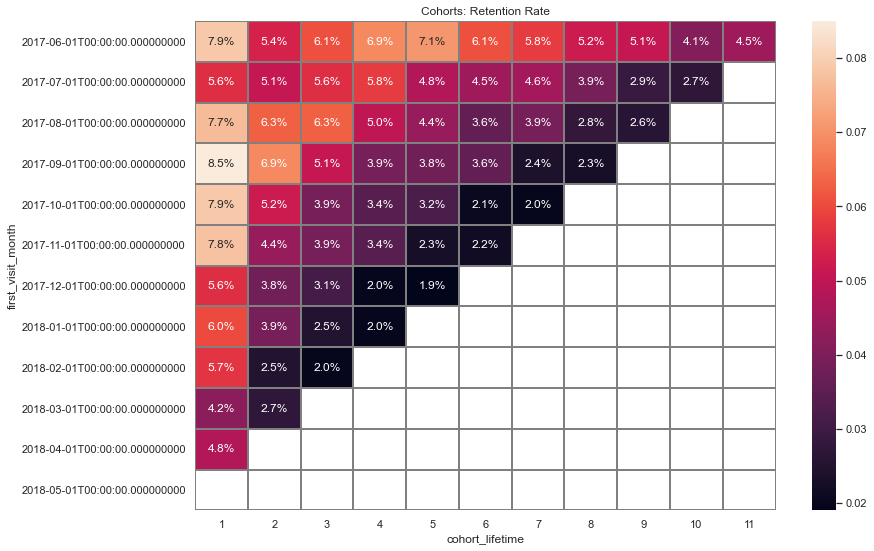

In [29]:
#тепловая карта
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Retention Rate')
sns.heatmap(retention_pivot.iloc[:,1:], annot=True, fmt='.1%', linewidths=1, linecolor='gray');

**Вывод** Retention Rate убывает по когортам с течением времени. Когорта пользователей, пришедшая в июле 2017 года демонстрирует рост показателя к четвертому месяцу жизни, затем показатель все-таки снижается. Июньская когорта(2017) сначала снижает показатель, потом немного повышает, и в целом демонстрирует лучший показатель возвращаемости среди других когорт. Есть тенденция к снижению показателя с каждой новой когортой. Следует выявить причины низкого Retention Rate когорты декабря - что изменилось в маркетинге в этот период?


#### Продажи<a id="sales"></a>
[к содержанию](#content)
   1. Когда люди начинают покупать?
   2. Сколько раз покупают за период?
   3. Какой средний чек?
   4. Сколько денег приносят? (LTV)

1. Когда люди начинают покупать?
   * Определим сколько времени проходит между первым посещением и первой покупкой 

Используем таблицу `first_visit`, которую мы создали при расчете Retention Rate, и создадим аналогичную с информацией о первой покупке.

In [30]:
#информация о первых заказах
first_order = orders.groupby(['uid']).agg({'buy_ts':'min'})
first_order = first_order.rename(columns={'buy_ts':'first_order'})
first_order = first_visit.merge(first_order, on='uid')
first_order['days_spent'] = (first_order['first_order'] - first_order['first_visit'])
first_order['days_spent'] = round(first_order['days_spent'] / np.timedelta64(1,'M'),0).astype(int)
first_order = first_order.sort_values(by='days_spent', ascending = False)
first_order

,first_visit,first_order,days_spent
uid,,,
2571629626051066012,2017-06-07 10:43:00,2018-05-29 09:26:00,12
16265474504222300952,2017-06-07 13:15:00,2018-05-28 11:03:00,12
14019942306387475502,2017-06-03 11:50:00,2018-05-21 22:28:00,12
10655808457602638638,2017-06-02 00:41:00,2018-05-23 12:15:00,12
6158008917228642735,2017-06-06 20:55:00,2018-05-28 15:02:00,12
...,...,...,...
7183783768312256289,2017-10-19 15:30:00,2017-10-19 15:35:00,0
7183270223136799568,2017-12-03 16:01:00,2017-12-03 16:04:00,0
7181622921618474794,2017-06-07 19:00:00,2017-06-07 19:00:00,0


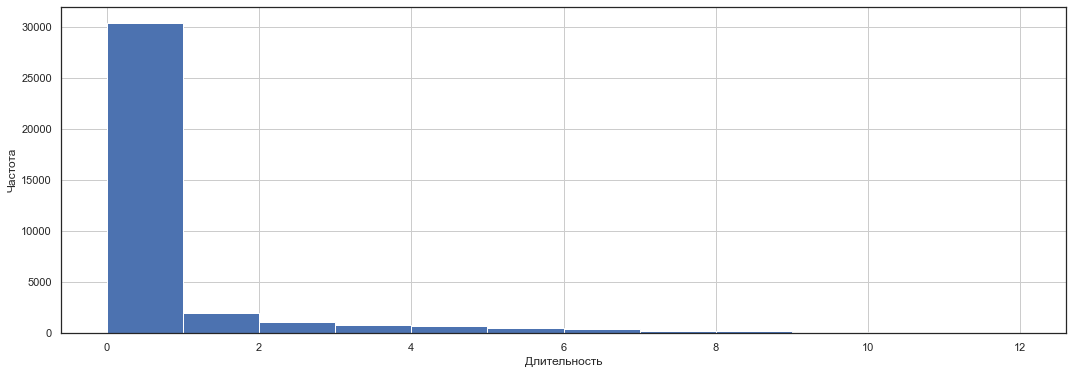

In [31]:
ax = plt.figure(figsize=(18, 6))
plt.hist(x=first_order['days_spent'], bins=12)

plt.grid(True)
plt.ylabel('Частота')
plt.xlabel('Длительность');

**Вывод** Большинство первых заказов осуществлено в день первого посещения. 28% пользователей совершили повторные покупки.


  2. Количество покупок за период 

Оценим, как меняется сумма покупок и их количество с течением времени. Для этого построим соответствующие графики с группировкой значения поля `buy_ts` по дням / неделям / месяцам.

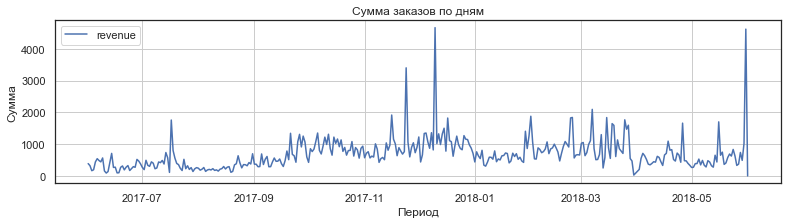

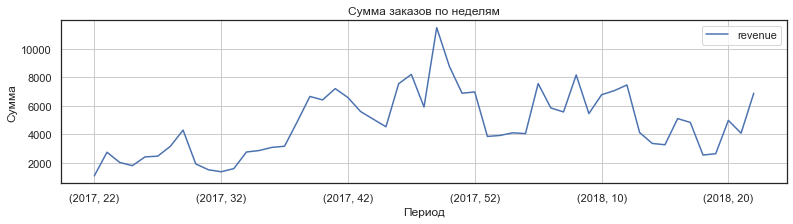

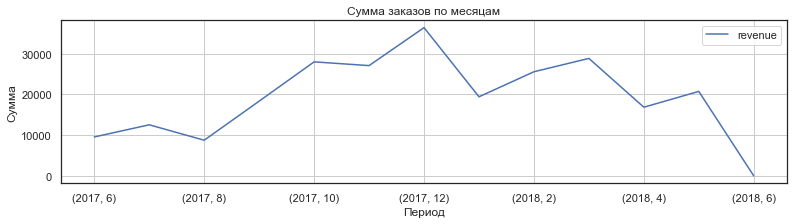

In [32]:
orders['orders_year']  = orders['buy_ts'].dt.year
orders['orders_month'] = orders['buy_ts'].dt.month
orders['orders_week']  = orders['buy_ts'].dt.week
orders['orders_date'] = orders['buy_ts'].dt.date

for i in ['orders_date',['orders_year', 'orders_week'],['orders_year', 'orders_month']]:
    orders.pivot_table(index = i, values = 'revenue', aggfunc = 'sum').plot(grid = True, figsize = (13,3))
    if i == 'orders_date':
        i = 'дням'
    elif i == ['orders_year', 'orders_week']:
        i = 'неделям'
    elif i == ['orders_year', 'orders_month']:
        i = 'месяцам' 
    plt.ylabel('Сумма')
    plt.xlabel('Период')
    plt.title('Сумма заказов по {}'.format (i))
    
    plt.show()

<a id="sale_count"></a>

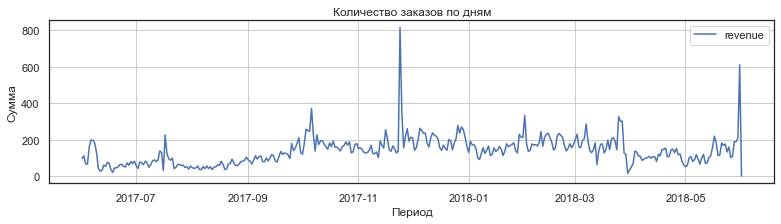

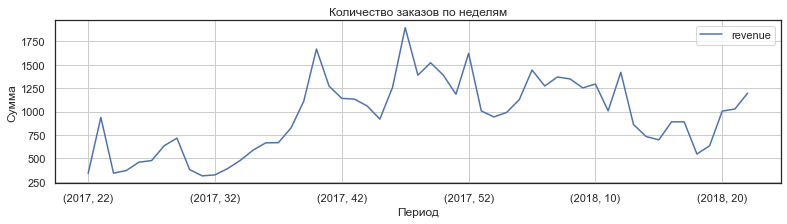

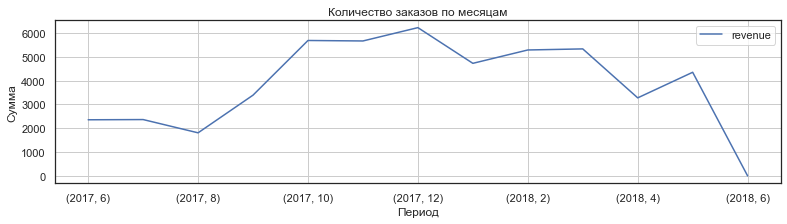

In [33]:
for i in ['orders_date',['orders_year', 'orders_week'],['orders_year', 'orders_month']]:
    orders.pivot_table(index = i, values = 'revenue', aggfunc = 'count').plot(grid = True, figsize = (13,3))
    if i == 'orders_date':
        i = 'дням'
    elif i == ['orders_year', 'orders_week']:
        i = 'неделям'
    elif i == ['orders_year', 'orders_month']:
        i = 'месяцам' 
    plt.ylabel('Сумма')
    plt.xlabel('Период')
    plt.title('Количество заказов по {}'.format (i))
    
    plt.show()

 Определим число покупок на одного покупателя в динамике.

In [34]:
orders['order_month'] = orders['orders_date'].astype('datetime64[M]')
#месяц первого заказа
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

#таблица с заказами с месяцем первой покупки
orders_new = pd.merge(orders,first_orders, on='uid')

#количество новых покупателей
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

#когорты по месяцу первого заказа
cohorts_ord = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

#когорты по месяцу первого заказа
cohorts_ord_cnt = orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue': ['sum', 'count']}).reset_index()
cohorts_ord_cnt.columns = ['first_order_month', 'order_month','rev_sum','rev_cnt']
#для вывода информации о среднем чеке в динамике
cohorts_ord_cnt['rev_per_user'] = cohorts_ord_cnt['rev_sum'] / cohorts_ord_cnt['rev_cnt']

#когорты с количеством новых покупателей
report_ord = pd.merge(cohort_sizes, cohorts_ord_cnt, on='first_order_month')
#столбец с числом покупок на 1 покупателя
report_ord['orders_by_user'] = report_ord['rev_cnt'] / report_ord['n_buyers'] 


Построим сводную таблицу с информацией о среднем количестве покупок на одного покупателя

In [35]:
report_ord.pivot_table(index='first_order_month',columns='order_month',values='orders_by_user',aggfunc='mean').round(2).fillna('')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,1.16,0.09,0.09,0.11,0.14,0.11,0.14,0.09,0.1,0.08,0.05,0.04,
2017-07-01,,1.14,0.05,0.06,0.05,0.04,0.04,0.03,0.03,0.03,0.01,0.03,
2017-08-01,,,1.12,0.08,0.07,0.06,0.06,0.05,0.04,0.06,0.03,0.03,
2017-09-01,,,,1.14,0.08,0.06,0.06,0.03,0.04,0.04,0.02,0.02,
2017-10-01,,,,,1.14,0.07,0.04,0.03,0.03,0.02,0.02,0.03,
2017-11-01,,,,,,1.18,0.1,0.04,0.05,0.03,0.01,0.02,
2017-12-01,,,,,,,1.15,0.06,0.05,0.04,0.02,0.02,
2018-01-01,,,,,,,,1.12,0.07,0.05,0.02,0.02,
2018-02-01,,,,,,,,,1.12,0.06,0.02,0.02,


Получили таблицу, выводы из которой аналогичны совершенным ранее (к примеру, изходя из информации в частотной гистограмме) - покупатели совершают покупки в первый месяц, некоторые из них возвращаются. В данной таблице видно, что со временем число покупок, приходящееся на одного покупателя уменьшается - лояльных покупателей очень мало. В общем, для каждой когорты покупателей показатели аналогичны.

**Вывод.** Графики о сумме и количестве заказов повторяют отмеченные ранее пиковое в конце ноября и провальное апрельское значение (в графике об уникальных посещениях), однако, в графике о сумме заказов форма более неравномерна и имеет пиковые значения. Это может свидетельствовать о покупках дорогостоящих билетов (или оптовая покупка - корпоративный поход в киношку). Сумма и количество заказов к концу рассматриваемого периода снижается (но это уже июнь, а в июне зафиксированы длящиеся с мая сессии и заказы). В целом, по заказам - оптимистичные графики: стабильность с тенденцией к росту. 


   3. Средний чек
      * Средний чек — сумма покупок, делённая на число покупателей
      * Средний чек на покупателя - сумма покупок, делённая на число уникальных покупателей

Средний чек, среднее значение:  4.94
Средний чек, минимальное значение:  1.95
Средний чек, максимальное значение 29.13


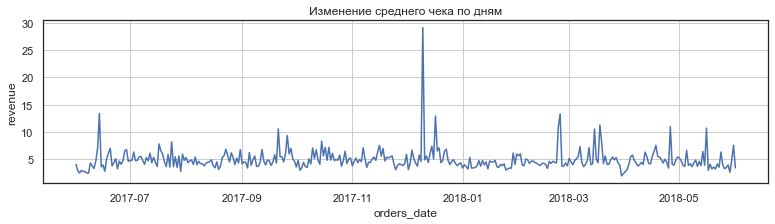

In [36]:
#средний чек по дням
orders_grouped_by_date = orders.groupby(['orders_date']).agg({'revenue':'sum','uid':'count'})
orders_grouped_by_date['revenue_per_user'] = orders_grouped_by_date['revenue'] / orders_grouped_by_date['uid']
print('Средний чек, среднее значение: ', round(orders_grouped_by_date['revenue_per_user'].mean(),2))
print('Средний чек, минимальное значение: ', round(orders_grouped_by_date['revenue_per_user'].min(),2))
print('Средний чек, максимальное значение', round(orders_grouped_by_date['revenue_per_user'].max(),2))

orders_grouped_by_date['revenue_per_user'].plot(grid = True, figsize = (13,3), title = 'Изменение среднего чека по дням')
plt.ylabel('revenue')
plt.show();

Средний чек на покупателя, среднее значение:  5.33
Средний чек на покупателя, минимальное значение:  2.25
Средний чек на покупателя, максимальное значение 32.15


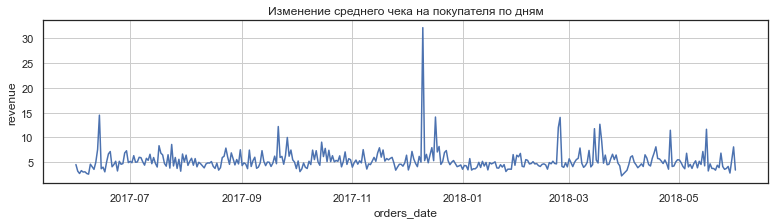

In [37]:
#средний чек на покупателя по дням
orders_grouped_by_date_uni = orders.groupby(['orders_date']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_date_uni['revenue_per_user'] = orders_grouped_by_date_uni['revenue'] / orders_grouped_by_date_uni['uid']
print('Средний чек на покупателя, среднее значение: ', round(orders_grouped_by_date_uni['revenue_per_user'].mean(),2))
print('Средний чек на покупателя, минимальное значение: ', round(orders_grouped_by_date_uni['revenue_per_user'].min(),2))
print('Средний чек на покупателя, максимальное значение', round(orders_grouped_by_date_uni['revenue_per_user'].max(),2))

orders_grouped_by_date_uni['revenue_per_user'].plot(grid = True, figsize = (13,3),\
                                                    title = 'Изменение среднего чека на покупателя по дням')
plt.ylabel('revenue')
plt.show();

Определим аналогичные значения в для периода в неделю и в один месяц:

Средний чек, среднее значение по неделям 4.95
Средний чек, минимальное значение по неделям 2.91
Средний чек, максимальное значение по неделям 7.55


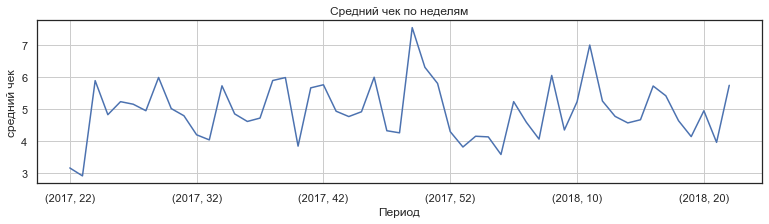

Средний чек, среднее значение по месяцам 4.84
Средний чек, минимальное значение по месяцам 3.42
Средний чек, максимальное значение по месяцам 5.85


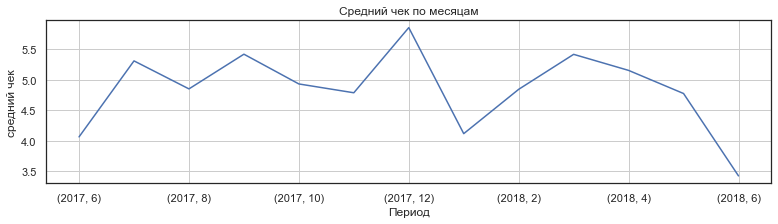

In [38]:
for i in [['orders_year', 'orders_week'],['orders_year', 'orders_month']]:
    orders_grouped_by_date = orders.groupby(i).agg({'revenue':'sum','uid':'count'})
    orders_grouped_by_date['revenue_per_user'] = orders_grouped_by_date['revenue'] / orders_grouped_by_date['uid']
    if i == 'orders_date':
        i = 'дням'
    elif i == ['orders_year', 'orders_week']:
        i = 'неделям'
    elif i == ['orders_year', 'orders_month']:
        i = 'месяцам' 
    print('Средний чек, среднее значение по {}'.format (i), round(orders_grouped_by_date['revenue_per_user'].mean(),2))
    print('Средний чек, минимальное значение по {}'.format (i), round(orders_grouped_by_date['revenue_per_user'].min(),2))
    print('Средний чек, максимальное значение по {}'.format (i), round(orders_grouped_by_date['revenue_per_user'].max(),2)) 
    
    orders_grouped_by_date['revenue_per_user'].plot(grid = True, figsize = (13,3));
    
    plt.ylabel('средний чек')
    plt.xlabel('Период')
    plt.title('Средний чек по {}'.format (i))
    
    plt.show()

 Определим средний чек покупок на одного покупателя в динамике.

In [39]:
cohorts_ord_cnt.pivot_table(index='first_order_month',columns='order_month',values='rev_per_user',aggfunc='mean').round(2).fillna('')


order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04,
2017-07-01,,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,
2017-08-01,,,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.7,5.6,
2017-09-01,,,,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,
2017-10-01,,,,,4.37,7.41,5.13,5.59,5.1,5.07,4.28,4.01,
2017-11-01,,,,,,4.37,4.1,4.47,6.28,4.44,3.73,4.6,
2017-12-01,,,,,,,4.11,4.23,20.07,26.08,15.95,14.11,
2018-01-01,,,,,,,,3.69,4.44,6.45,7.52,2.71,
2018-02-01,,,,,,,,,3.71,4.58,3.45,3.87,


Построили сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и можем оценить, как изменяется средний чек с течением времени. В этой таблице мы вперые встречаемся с аномальными отклонениями на четвертый месяц жизни сентябрьской когорты. Немного меньше, но похоже: величины среднего чека в декабрьской когорте на третий месяц.


**Вывод** Определены величины среднего чека и среднего чека на покупателя. Величины немного отличаюся, то есть в течение дня некоторые пользователи производили покупки разными заказами. Для покупок на сайте, вероятно, различие показателей (средний чек и средний ек на покупателя) не имеет сильного значения, т.к. обслуживание одного заказа (покупки) в данном случае имеет незначительную стоимость.
Средний чек в зимние каникулы значительно увеличивается, после чего происходит естественное снижение. Причем, увеличение декабря происходит засчет больших значений, являющихся пиками на дневном графике. То есть долгосрочное февральское снижение среднего чека - это компенсация нескольких дней с высокими продажами.
Здесь также имеется значение июня 2018 (определено на единичных заказах, не следует принимать во внимание).

 4. Сколько денег приносят? (LTV)
     * LTV (от англ. lifetime value) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок.


Построим LTV клиента по когортам и визуализируем в "тепловой карте". Для того, чтобы построить метрику в зависимости от источника трафика, дополним таблицу `orders` соответствующей информацией.

In [40]:
#к таблице с заказами добавим первый источник перехода
users_with_source = visits.sort_values(by = 'start_ts').groupby('uid', as_index = False).agg({'source_id' : 'first'})
orders = orders.merge(users_with_source, how = 'left', on = 'uid')

#таблица с заказами с месяцем первой покупки
orders_new = pd.merge(orders,first_orders, on='uid')
#когорты по месяцу первого заказа

cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#когорты с количеством новых покупателей
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

#маржинальность не задана, принимаем за единицу
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

#разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


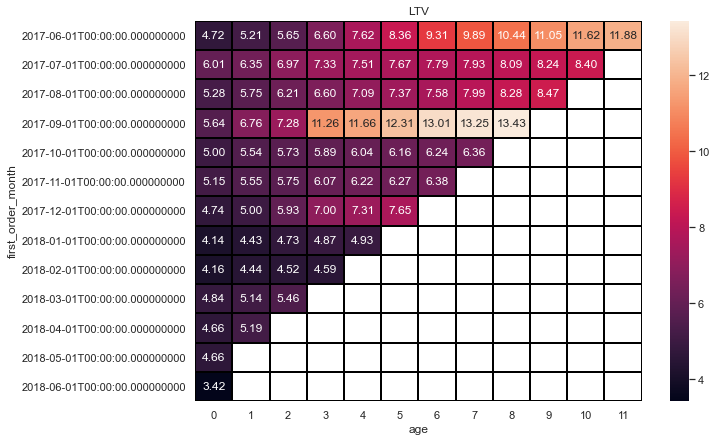

In [41]:
plt.figure(figsize=(10, 7))
plt.title('LTV')
sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='black')
plt.show()

Получили когортный отчет в виде сводной таблицы, сформированной по возрастам когорты и тепловую карту. Самые высокие показатели в первый месяц (как мы определили ранее - пользователи покупают в периоды первого посещения), в сентябрьской когорте отмечается значительный рост на четвертый месяц. Когорта июня 2017 года - имеет самые высокие показатели LTV за период жизни. Посчитаем показатель для первой когорты.

In [42]:
#LTV когорты 1
ltv_201706 = output.loc['2017-06-01'].sum().round(2)

#LTV когорты 6 (дополнено)
ltv_201711 = output.loc['2017-11-01'].sum().round(2)

print('LTV первой когорты: ', ltv_201706)
print('LTV шестой когорты: ', ltv_201711)

LTV первой когорты:  11.88
LTV шестой когорты:  6.38


В среднем каждый покупатель из первой когорты принес по 11,8 выручки за год «жизни», покупатель шестой когорты - в среднем 6,4. Те же результаты результат по каждой когорте явно видны в последней ячейке тепловой карты, выше. Значения ltv для разных когорт неодинаковы и могут иметь разброс.

Оценим показатель, построив "тепловые карты" для разных источников трафика. Построим их с использованием таблицы - словаря `source_costs`, созданной [ранее](#source_id_table). Графики построим в порядке убывания суммарного значения costs, то есть, начиная с источника, в который вложено больше всего затрат. <a id="ltv"></a>

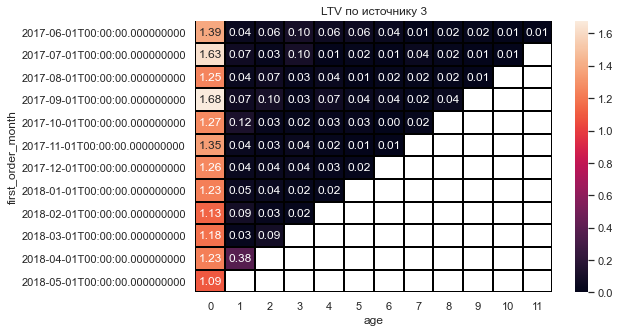

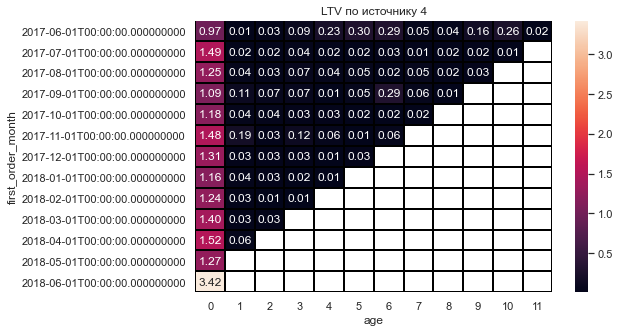

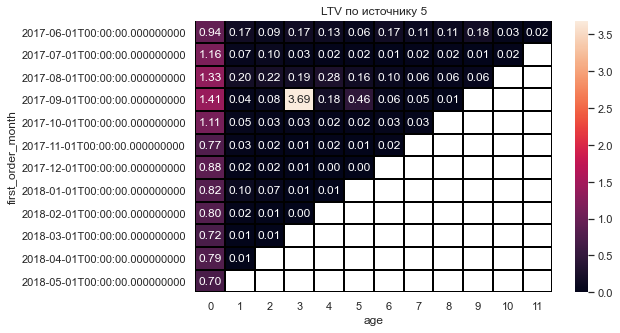

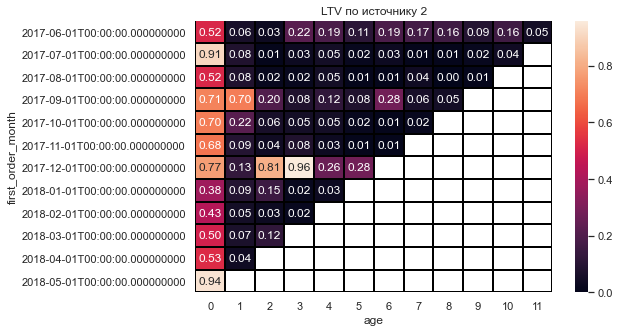

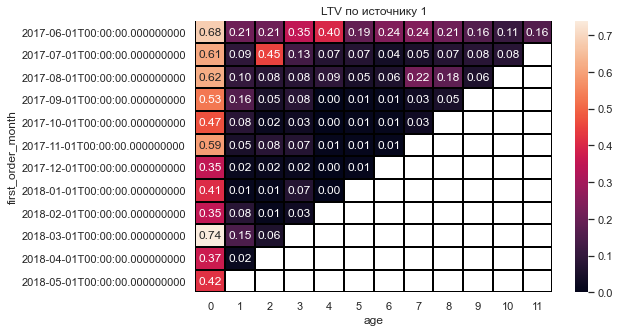

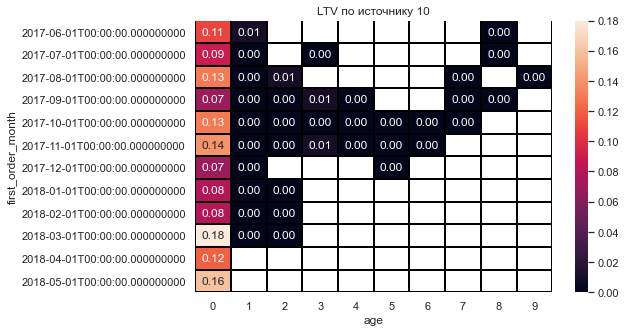

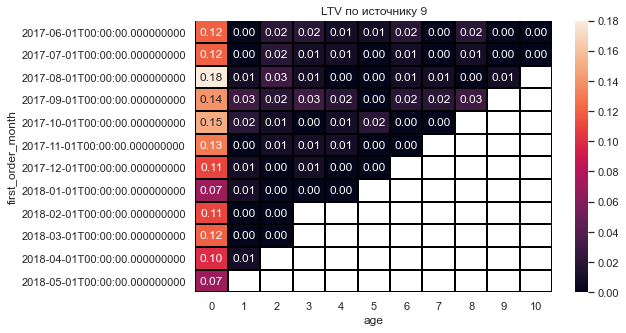

In [43]:
#когорты по месяцу первого заказа и по источникам
cohorts_by_source = orders_new.groupby(['first_order_month','order_month', 'source_id']).agg({'revenue': 'sum'}).reset_index()
#когорты с количеством повых покупателей
report_by_source = pd.merge(cohort_sizes, cohorts_by_source, on='first_order_month')

#маржинальность не задана, принимаем за единицу
margin_rate = 1
report_by_source['gp'] = report_by_source['revenue'] * margin_rate
report_by_source['age'] = (report_by_source['order_month'] - report_by_source['first_order_month']) / np.timedelta64(1, 'M')
report_by_source['age'] = report_by_source['age'].round().astype('int')

#разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте
report_by_source['ltv'] = report_by_source['gp'] / report_by_source['n_buyers']
    
#цикл для построения метрики по источникам трафика
for i in source_costs.index:
    output_source = report_by_source[report_by_source['source_id'] == i].pivot_table(
                  index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)
    plt.figure(figsize=(8, 5))
    plt.title('LTV по источнику {}'.format (i))
    sns.heatmap(output_source, annot=True, fmt='.2f', linewidths=1, linecolor='black')
    plt.show()

Значение ltv на четвертый месяц жизни сентябрьской когорты - вряд ли какая-то закономерность, поэтому стоит оценить причину такого показателя

In [44]:
orders_new[(orders_new['first_order_month'] == '2017-09-01')&(orders_new['source_id'] == 5)\
           &(orders_new['orders_month'] == 12)].sort_values(by = 'revenue', ascending = False).head(10)

,buy_ts,revenue,uid,orders_year,orders_month,orders_week,orders_date,order_month,source_id,first_order_month
11732,2017-12-10 20:17:00,2633.28,5539673724080479777,2017,12,49,2017-12-10,2017-12-01,5,2017-09-01
11730,2017-12-10 13:04:00,1195.64,5539673724080479777,2017,12,49,2017-12-10,2017-12-01,5,2017-09-01
11745,2017-12-15 21:22:00,604.39,5539673724080479777,2017,12,50,2017-12-15,2017-12-01,5,2017-09-01
11724,2017-12-05 00:50:00,402.72,5539673724080479777,2017,12,49,2017-12-05,2017-12-01,5,2017-09-01
11728,2017-12-08 12:25:00,360.55,5539673724080479777,2017,12,49,2017-12-08,2017-12-01,5,2017-09-01
11723,2017-12-04 18:40:00,344.36,5539673724080479777,2017,12,49,2017-12-04,2017-12-01,5,2017-09-01
11750,2017-12-18 19:07:00,337.33,5539673724080479777,2017,12,51,2017-12-18,2017-12-01,5,2017-09-01
11759,2017-12-22 19:43:00,304.94,5539673724080479777,2017,12,51,2017-12-22,2017-12-01,5,2017-09-01
11733,2017-12-11 23:52:00,293.03,5539673724080479777,2017,12,50,2017-12-11,2017-12-01,5,2017-09-01
11731,2017-12-10 15:58:00,243.83,5539673724080479777,2017,12,49,2017-12-10,2017-12-01,5,2017-09-01


Оценим сумму покупкок пользователя "5539673724080479777"   

In [45]:
for i in [9,10,11,12,1,2,3,4,5]:
    print(i, '-ый месяц года, сумма покупки пользователя "777":', orders_new[
          (orders_new['first_order_month'] == '2017-09-01')
           &(orders_new['source_id'] == 5)
           &(orders_new['orders_month'] == i)
           &(orders_new['uid'] == 5539673724080479777)
           ]['revenue'].sum())

9 -ый месяц года, сумма покупки пользователя "777": 578.4
10 -ый месяц года, сумма покупки пользователя "777": 0.0
11 -ый месяц года, сумма покупки пользователя "777": 147.88
12 -ый месяц года, сумма покупки пользователя "777": 9253.7
1 -ый месяц года, сумма покупки пользователя "777": 420.74
2 -ый месяц года, сумма покупки пользователя "777": 1157.09
3 -ый месяц года, сумма покупки пользователя "777": 146.96
4 -ый месяц года, сумма покупки пользователя "777": 105.41
5 -ый месяц года, сумма покупки пользователя "777": 0.0


В другие месяцы он также совершал покупки, хорошо бы узнать причины такой лольности... однако, в пятом месяце сумма покупок = 0. 

**Вывод.** По источникам 3 и 4 хороший показатель LTV первого месяца, а далее цифры ниже, чем в других источниках в аналогичный период.  По источнику 5 хорошие показатели первого месяца и именно по этому источнику - неожиданно высокое значение на четвертый месяц жизни в сентябрьской когорте (в декабре), причина которого - сумма покупок одного пользователя.  Пользователи, впервые пришедшие по источнику 2, демонстрируют хороший LTV, особенно, когорта декабря на третий и четвертый месяц жизни. Первая когорта пользователей (июнь 2017), пришедшая по источнику 1, продолжает совершать покупки на протяжении всего lifetime. По источникам 9 и 10 - результаты только в первый месяц жизни когорты.


#### Маркетинг<a id="marketing"></a>
[к содержанию](#content)
   1. Сколько денег потратили? Всего / на каждый источник / по времени
   2. Сколько стоило привлечение одного покупателя из каждого источника?
   3. На сколько окупились расходы? (ROI)

1.  Сколько денег потратили? Всего / на каждый источник / по времени

Общие показатели определены [ранее](#costs). Оценим, как менялись затраты с течением времени с разбивкой на разные источники

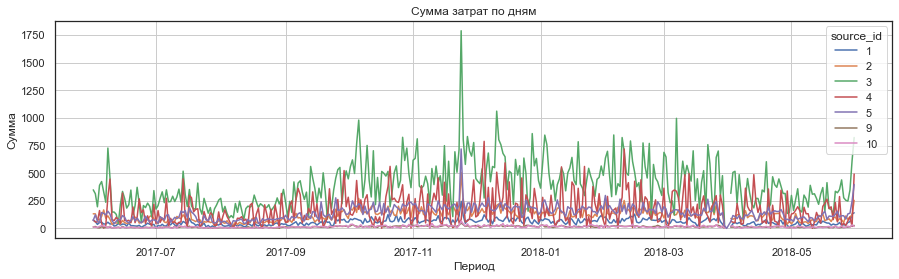

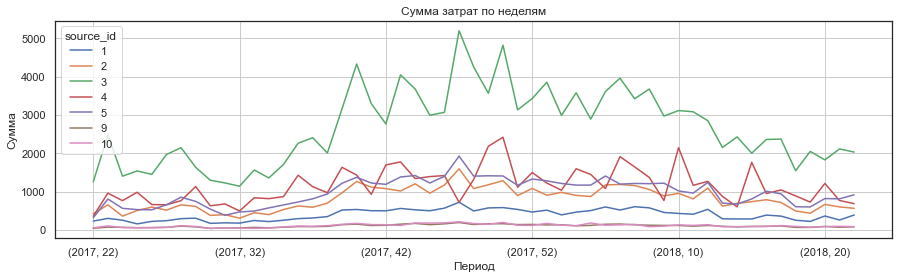

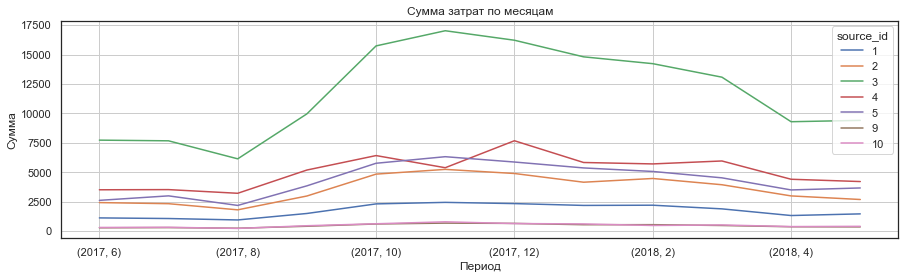

In [46]:
costs['costs_year']  = costs['dt'].dt.year
costs['costs_month'] = costs['dt'].dt.month
costs['costs_week']  = costs['dt'].dt.week
costs['costs_date'] = costs['dt'].dt.date

for i in ['costs_date',['costs_year', 'costs_week'],['costs_year', 'costs_month']]:
    costs.pivot_table(index = i,  columns = 'source_id', values = 'costs', aggfunc = 'sum').plot(grid = True, figsize = (15,4))
    if i == 'costs_date':
        i = 'дням'
    elif i == ['costs_year', 'costs_week']:
        i = 'неделям'
    elif i == ['costs_year', 'costs_month']:
        i = 'месяцам' 
    plt.ylabel('Сумма')
    plt.xlabel('Период')
    plt.title('Сумма затрат по {}'.format (i))
    
    plt.show()

На источник 3 потрачено больше всего денег. При этом, пик в период ноябрь-декабрь на графике с [привлеченными пользователями](#customers) и с [количеством покупок](#sale_count), совпадает с пиком максимальных затрат по этому источнику. Исходя из результатов расчета LTV для этого [источника](#ltv) нельзя сказать, что этот источник привлечения пользователей является эффективным. Начиная с августа затраты на маркетинг увеличились и в основном засчет трат на 3-й источник привлечения покупателей.


   2. Стоимость привлечения одного покупателя из каждого источника.

Общая информация о стоимости привлечения пользователей по когортам

In [47]:
#для объединения вернем столбец в тип даты
costs['costs_month'] = costs['dt'].astype('datetime64[M]') 

#информация о затратах в месяц
monthly_costs = costs.groupby('costs_month').agg({'costs':'sum'}).reset_index()
#выполним объединение и посчитаем cac
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='costs_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,costs_month,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,2017-06-01,18015.00,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,2017-06-01,18015.00,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,2017-06-01,18015.00,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,2017-06-01,18015.00,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,2017-06-01,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1,0.300892,2018-03-01,30415.27,8.608907
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559,2018-03-01,30415.27,8.608907
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597,2018-04-01,22289.38,9.793225
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599,2018-04-01,22289.38,9.793225


Информация и стоимости привлечения пользователей с группировкой по когортам 

In [48]:
output_cac = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='cac', 
        aggfunc='mean').round(2)
    
output_cac.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,8.91,8.91,8.91,8.91,8.91,8.91,8.91,8.91,8.91,8.91,8.91,8.91
2017-07-01,9.49,9.49,9.49,9.49,9.49,9.49,9.49,9.49,9.49,9.49,9.49,
2017-08-01,10.80,10.8,10.8,10.8,10.8,10.8,10.8,10.8,10.8,10.8,,
2017-09-01,9.44,9.44,9.44,9.44,9.44,9.44,9.44,9.44,9.44,,,
2017-10-01,8.37,8.37,8.37,8.37,8.37,8.37,8.37,8.37,,,,
2017-11-01,9.29,9.29,9.29,9.29,9.29,9.29,9.29,,,,,
2017-12-01,8.74,8.74,8.74,8.74,8.74,8.74,,,,,,
2018-01-01,9.94,9.94,9.94,9.94,9.94,,,,,,,
2018-02-01,8.96,8.96,8.96,8.96,,,,,,,,


Определим значение CAC в зависимости от источника трафика

In [49]:
monthly_costs1 = costs.groupby(['costs_month', 'source_id']).agg({'costs':'sum'}).reset_index()
#выполним объединение  и посчитаем с разбивкой на источники трафика
report_new1 = pd.merge(report, monthly_costs1, left_on='first_order_month', right_on='costs_month')
report_new1['cac'] = (report_new1['costs'] / report_new1['n_buyers']).round(2)
report_new1

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,costs_month,source_id,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,2017-06-01,1,1125.61,0.56
1,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,2017-06-01,2,2427.38,1.20
2,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,2017-06-01,3,7731.65,3.82
3,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,2017-06-01,4,3514.80,1.74
4,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,2017-06-01,5,2616.12,1.29
...,...,...,...,...,...,...,...,...,...,...,...
541,2018-05-01,2988,2018-05-01,13925.76,13925.76,0,4.660562,2018-05-01,3,9411.42,3.15
542,2018-05-01,2988,2018-05-01,13925.76,13925.76,0,4.660562,2018-05-01,4,4214.21,1.41
543,2018-05-01,2988,2018-05-01,13925.76,13925.76,0,4.660562,2018-05-01,5,3669.56,1.23
544,2018-05-01,2988,2018-05-01,13925.76,13925.76,0,4.660562,2018-05-01,9,362.17,0.12


Построим сводню таблицу с информацией о стоимости привлечения одного пользователя (в среднем) в зависсимости от источника.

In [50]:
report_new1.pivot_table(index = 'age', columns = 'source_id', values = 'cac', aggfunc = 'mean').round(2)

source_id,1,2,3,4,5,9,10
age,,,,,,,
0,0.58,1.19,3.91,1.74,1.43,0.15,0.16
1,0.58,1.21,3.97,1.76,1.45,0.16,0.16
2,0.58,1.20,3.96,1.75,1.44,0.15,0.16
3,0.59,1.21,3.99,1.75,1.46,0.16,0.16
4,0.59,1.21,4.00,1.78,1.47,0.16,0.17
5,0.58,1.20,3.95,1.78,1.45,0.16,0.17
6,0.59,1.22,3.99,1.79,1.47,0.16,0.17
7,0.58,1.20,3.96,1.88,1.45,0.16,0.16
8,0.60,1.22,4.04,1.98,1.48,0.16,0.17


Самый дорогой источник трафика - №3, это видно и на предыдущих графиках.К сожалению, не все привлеченные пользователи стаановятся покупателями, не все затраты могут окупиться.

  3. На сколько окупились расходы? (ROI)
   * Экономика одного покупателя сходится, если LTV больше CAC.

Сперва оценим, когда в общем начинают окупаться затраты.

In [51]:
#для объединения вернем столбец в тип даты
costs['costs_month'] = costs['dt'].astype('datetime64[M]') 

#информация о затратах в месяц
monthly_costs = costs.groupby('costs_month').agg({'costs':'sum'}).reset_index()
#выполним объединение и посчитаем cac
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='costs_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


Первая (июньская) когорта окупилась на шестой месяц (ROMI = 1.05). Сентябрьская когорта окупилась на третий месяц (вспомним про ...777). Остальные все еще не окупились.

Проверить предположение, что источник привлечения 3 - бочка дегтя в ложке меда....

In [52]:
#количество людей в когортах по первому заказу с разбивкой на источники
orders_new_uid_cnt = orders_new.groupby(['first_order_month','source_id']).agg({'uid':'nunique'}).reset_index()
#суммируем выручку по источникам в когортах
orders_new_rev = orders_new.groupby(['first_order_month','order_month','source_id']).agg({'revenue':'sum'}).reset_index()
orders_cac = pd.merge(orders_new_uid_cnt, orders_new_rev, left_on=['source_id', 'first_order_month'], right_on=['source_id', 'first_order_month'])
orders_cac['ltv'] = orders_cac['revenue'] / orders_cac['uid']

orders_cac['age'] = (orders_cac['order_month'] - orders_cac['first_order_month']) / np.timedelta64(1, 'M')
orders_cac['age'] = orders_cac['age'].round().astype('int')

orders_cac = pd.merge(monthly_costs1,orders_cac, left_on=['costs_month', 'source_id'], right_on=['order_month', 'source_id'])
orders_cac['cac'] = orders_cac['costs']/orders_cac['uid']
orders_cac['romi'] = orders_cac['ltv']/orders_cac['cac']

Построим накопительные ROMI по источникам на тепловой карте в порядке убывания затрат на источник.

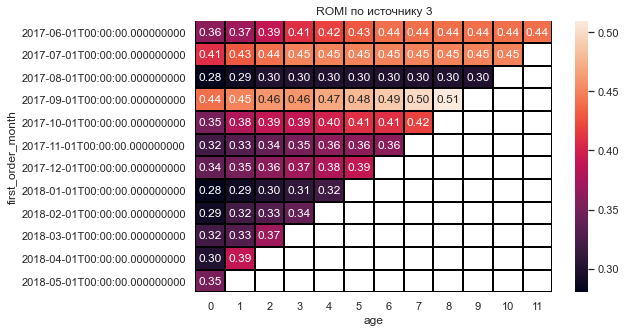

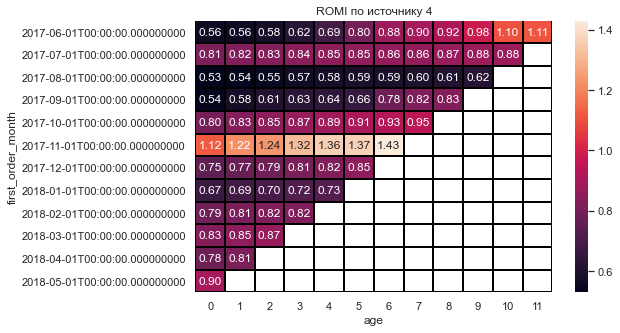

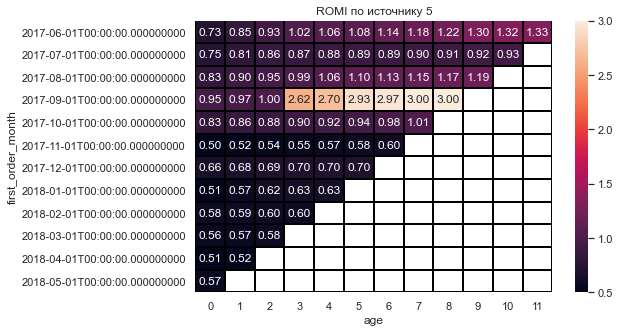

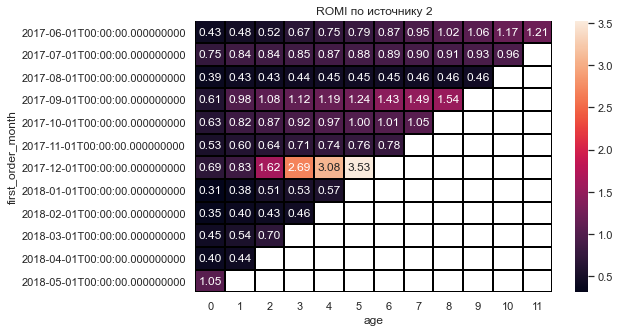

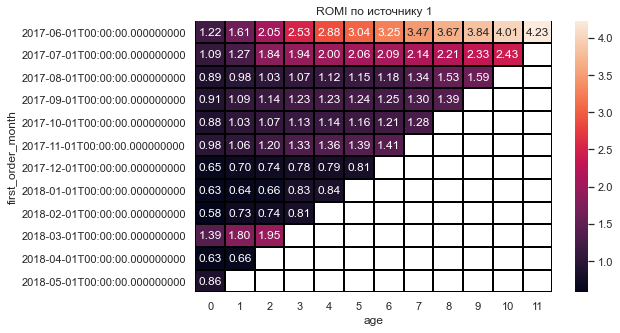

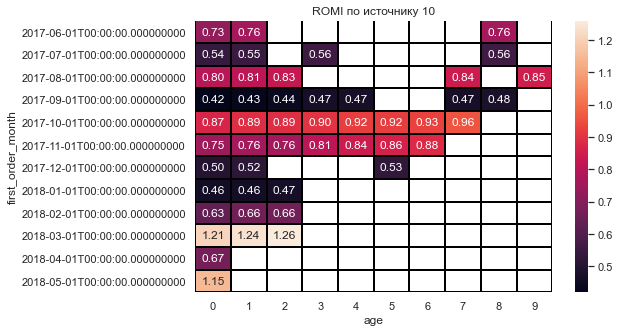

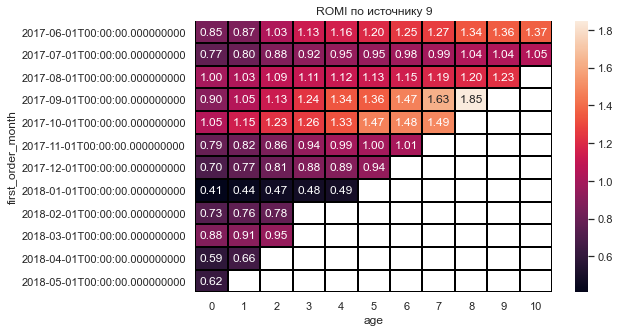

In [53]:
for i in source_costs.index:
    
    output_source = orders_cac[orders_cac['source_id'] == i].pivot_table(
                  index='first_order_month', columns='age', values='romi', aggfunc='mean').round(2)
    plt.figure(figsize=(8, 5))
    plt.title('ROMI по источнику {}'.format (i))
    sns.heatmap(output_source.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='black')
    plt.show()

**Вывод.** Действительно, по источнику №3 затраты не окупились ни в одной когорте. Источник № 4 - показатели лучше, но окупились только две когорты, причем, ноябрьская, в первый месяц. По источнику 5 - четыре когорты окупили затраты (это источник привлечения пользователя "777"). По источнику 2 - 5 когорт окупились, но результат очень неравномерный, поэтому сложно прогнозируемый.
Источники 1 и 9 - на мой взгляд, лучшие. Рост показателя равномерный и стабильный. По источнику 10 - малое количество переходов, сложно оценить его romi, но эффективность невысокая. И оценим процент всех пользователей по наиболее эффективным источникам.

In [54]:
round(100*(len(visits[visits['source_id'] == 1] )/ len(visits)),2)

9.49

In [55]:
round(100*(len(visits[visits['source_id'] == 9]) / len(visits)),2)

3.69

### Шаг 3. Вывод<a id="resume"></a>
[к содержанию](#content)

* На основании данных Яндекс.Афиши с июня 2017 по конец мая 2018 года определены основные показатели продаж услуг пользователям сервиса. Данные представлены в виде информации о сведений о посещениях сайта, информации о заказах и статистике рекламных расходов.
* представленные данные достаточно чистые и потребовалось только преобразовать даты: сбор и хранение данных осуществляется клиентом верно.
* Наиболее частая длительность сессии меньше минуты должно насторожить, возможно наша реклама не достаточно таргетирована и мы привлекаем много случайных посетителей<
* В большинстве случаев (63%) - пользователи впервые на сайте. Больше пользователей с десктопных устройств, времени на сайте они проводят также больше.
* Всего совершено 50415, из них 72% - уникальные пользователи. Средний чек - 5, однако, имеются значительные заказы на большую сумму, а также заказы стоимостью 0 (акционные предложения или оплата не в денежном выражении).
* Суммарные затраты на маркетинг (329131.62) превысили выручку на 23%, Некоторые источники трафика (6, 7 и 8) значит, они не имеют стоимости. За весь период почти половина всех затрат пришлась на источник №3, который оказался самым неэффективным с точки зрения показателя ROMI.
* Определены метрики активности пользователей: DAU:  907, WAU:  5716, MAU:  23228. При этом десктопные пользователи менее активны в выходные дни, и в холодное время года за представленный период активность пользователей была выше.
* Источник трафика №3 - на втором месте по привлечению новых пользователей. 
* Пользователи обычно совершают первую покупку в первый день посещения сайта, но иногда они возвращаются. Есть пользователи, которые совершают покупки на значительную сумму. Следует выяснить информацию о клиенте (777). Возможно, стоит предложить некоторым лояльным клиентам более гибкие условия (если существует риск ухода).
* Пользовательские метрики посчитаны, проведен когортный анализ, на основании которого можно рекомендовать снизить затраты на источник трафика № 3 (не менее чем на 25%), не отказываясь от него, а сместив использование этого ресурса в периоды перед каникулами (выходными), когда конкуренция повышается. 
* Наиболее затратные источники трафика 3,4,5 привлекли наибольшее число новых пользователей, но по ROMI они менее эффективны
* Когорта июня 2017 года по большинству источников демонстрирует лучшие показатели.
* Около 10% пользователей с лучшим показателем ROMI пришли на сайт с источника №1, который рекомендуется для развития.
